In [1]:
# Imports
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm

In [2]:
train_mask_dir = "/home/ani/Documents/datasets/coco/masks/train/"
val_mask_dir = "/home/ani/Documents/datasets/coco/masks/val/"

train_images = glob(os.path.join(train_mask_dir, "*"))
val_images = glob(os.path.join(val_mask_dir, "*"))

Dims:  (100, 100, 3)


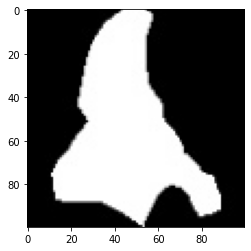

In [3]:
img_path = train_images[0]
img = cv2.imread(img_path)
print("Dims: ", img.shape)
plt.imshow(img[:,:,::-1])
plt.show()

Input Shape: (10, 100, 100, 3), Target Shape: (10, 100, 100, 1)


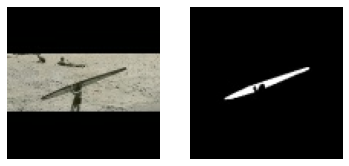

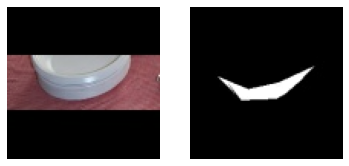

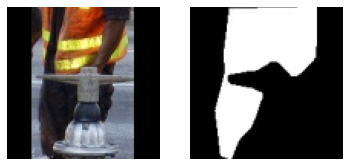

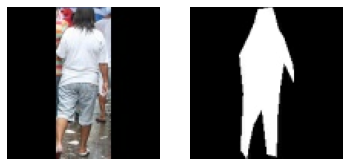

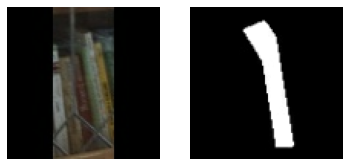

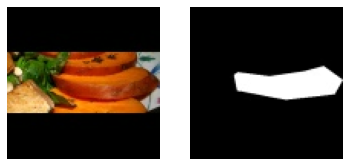

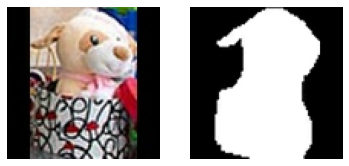

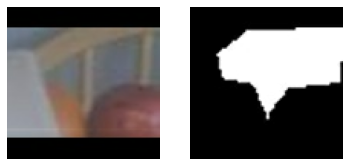

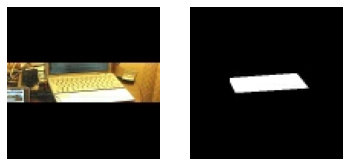

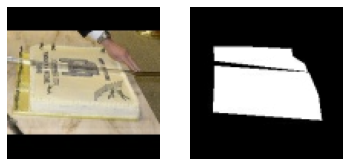

In [4]:
# A quick Tensorflow Data loader
class DataLoader:
    """
    Assuming Dataset Path Structure:
    - Train Images: /media/ActiveTraining/Datasets/COCO/images/train
    - Val Images: /media/ActiveTraining/Datasets/COCO/images/val
    - Train Masks: /media/ActiveTraining/Datasets/COCO/masks/train
    - Val Masks: /media/ActiveTraining/Datasets/COCO/masks/val
    """
    def __init__(self, masks_dir, target_shape=(100, 100)):
        masks_dir = self.__fix_glob(masks_dir)
        self.files = tf.data.Dataset.list_files(masks_dir, shuffle=True)
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.target_shape = target_shape
        
    def __fix_glob(self, dir_path):
        if not dir_path.endswith("*"):
            dir_path = os.path.join(dir_path, "*")
            
        return dir_path
    
    @tf.function
    def parse_images(self, mask_path):
        mask = tf.io.read_file(mask_path)
        mask = tf.io.decode_jpeg(mask, channels=1)
        mask = tf.cast(mask, tf.float32)
        
        image_path = tf.strings.regex_replace(mask_path, "masks", "images")
        image = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32)
        
        mask = tf.image.resize(
            mask, 
            self.target_shape, 
        ) / 255.
        
        image = tf.image.resize(
            image, 
            self.target_shape, 
        ) / 255.
        
        return image, mask
    
    @tf.function
    def data_generator(self, batch_size=64):
        dataset = self.files.map(self.parse_images)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size = self.AUTOTUNE)
        return dataset
    
test_dataset = DataLoader(train_mask_dir)
batch = test_dataset.data_generator(10)
inputs, targets = next(iter(batch))
print(f"Input Shape: {inputs.shape}, Target Shape: {targets.shape}")

for i, t in zip(inputs, targets):
    plt.subplot(1, 2, 1)
    plt.imshow(i)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(t, cmap="gray")
    plt.axis("off")
    plt.show()

In [5]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [6]:
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "weights.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=10e-8,
)


# Hyper Params
batch_size = 32
epochs = 200
lr = 0.001
target_shape=(160, 160)


# Initialize Model
autoencoder = get_model(target_shape, 1)
autoencoder.summary()

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=lr)

autoencoder.compile(
    loss="binary_crossentropy", 
    optimizer=opt, 
    metrics=[
        "mse",
])

# Dataset Generator
train_dataset = DataLoader(train_mask_dir, target_shape=target_shape)
train_generator = train_dataset.data_generator(batch_size)

val_dataset = DataLoader(val_mask_dir, target_shape=target_shape)
val_generator = val_dataset.data_generator(batch_size)

# Calculate Num Steps
train_steps = len(list(train_dataset.files)) // batch_size + 1
val_steps = len(list(val_dataset.files)) // batch_size + 1

# Train
history = autoencoder.fit(
    train_generator,
    validation_data=val_generator,
    batch_size=batch_size, 
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Epoch 1/200
16025/16025 [==============================] - 1751s 109ms/step - loss: 0.2762 - mse: 0.0797 - val_loss: 0.2338 - val_mse: 0.0666
Epoch 2/200
16025/16025 [==============================] - 1795s 112ms/step - loss: 0.2180 - mse: 0.0612 - val_loss: 0.2143 - val_mse: 0.0600
Epoch 3/200
16025/16025 [==============================] - 1738s 108ms/step - loss: 0.2050 - mse: 0.0570 - val_loss: 0.2078 - val_mse: 0.0579
Epoch 4/200
16025/16025 [==============================] - 1736s 108ms/step - loss: 0.1972 - mse: 0.0544 - val_loss: 0.2035 - val_mse: 0.0564
Epoch 5/200
16025/16025 [==============================] - 1737s 108ms/step - loss: 0.1921 - mse: 0.0527 - val_loss: 0.2060 - val_mse: 0.0565
Epoch 6/200
16025/16025 [==============================] - 1708s 107ms/step - loss: 0.1867 - mse: 0.0510 - val_loss: 0.2231 - val_mse: 0.0611
Epoch 7/200
16025/16025 [==============================] - 1680s 105ms/step - loss: 0.1833 - mse: 0.0499 - val_loss: 0.2264 - val_mse: 0.0617
Epoch 